In [78]:
import pandas as pd
import time
from datetime import datetime, timedelta
from pytz import timezone
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle

In [79]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [80]:
ticker = 'TRX'
delta = timedelta(hours=2)

In [81]:
features_onchain_merged = pd.read_pickle("../pickles/features_onchain_merged_onchain_exchange.pickle")

In [82]:
onchain_burnrates = pd.read_csv("../data/train/burnrates_train.csv")

In [83]:
onchain_burnrates.head()

,Unnamed: 0,burnRate,datetime,name,ticker
0,0,1.081740e+11,2018-03-01T00:00:00Z,0x,ZRX
1,1,2.484295e+10,2018-03-01T02:00:00Z,0x,ZRX
2,2,2.679559e+09,2018-03-01T04:00:00Z,0x,ZRX
3,3,4.432177e+09,2018-03-01T06:00:00Z,0x,ZRX
4,4,1.293058e+10,2018-03-01T08:00:00Z,0x,ZRX


In [84]:
#onchain_burnrates['ticker'].unique()

In [85]:
min_date = datetime.strptime("2018-03-01 00:00:00","%Y-%m-%d %H:%M:%S")

In [86]:
%%time
news_dates = onchain_burnrates['datetime'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
onchain_burnrates['date_datetime'] = news_dates
onchain_burnrates = onchain_burnrates.sort_values(by = 'date_datetime', ascending = True)


CPU times: user 3.73 s, sys: 3.9 ms, total: 3.73 s
Wall time: 3.73 s


In [87]:
def build_timeSlots(df, colname):
    min_date = datetime.strptime("2018-03-01 00:00:00","%Y-%m-%d %H:%M:%S")
    cur_date = min_date
    max_date = datetime.now()
    delta = timedelta(hours=2)
    print min_date, max_date 
    tmpDict = {}
    ll = []
    
    while cur_date < max_date:
        indices = df[(df[colname]>=cur_date) & (df[colname]< cur_date + delta)].index
        tmpDF = pd.DataFrame({'cur_date': cur_date, 'max_date': cur_date + delta}, index = indices)
        #print cur_date, max_date
        #print len(indices), tmpDF.shape[0]
        #tmpDF = df[(df[colname]>=min_date) & (df[colname]< cur_date + delta)].copy()
        if tmpDF.shape[0] == 0:
            break;
        cur_date = cur_date + delta
        ll.append(tmpDF)
    return ll
result = build_timeSlots(onchain_burnrates, 'date_datetime')
onchain_burnrates_with_timeslots =  pd.concat(result)

2018-03-01 00:00:00 2018-07-07 11:27:21.538705


In [88]:
onchain_burnrates_with_timeslots.shape

(215491, 2)

In [89]:
onchain_burnrates = onchain_burnrates[onchain_burnrates['date_datetime']>min_date]
onchain_burnrates = onchain_burnrates.merge(onchain_burnrates_with_timeslots, left_index = True, right_index = True)

In [90]:
onchain_burnrates.head()

,Unnamed: 0,burnRate,datetime,name,ticker,date_datetime,cur_date,max_date
3405,1,4.624551e+09,2018-03-01T02:00:00Z,Aditus,ADI,2018-03-01 02:00:00,2018-03-01 02:00:00,2018-03-01 04:00:00
7552,1,7.060660e+07,2018-03-01T02:00:00Z,Aion,AION,2018-03-01 02:00:00,2018-03-01 02:00:00,2018-03-01 04:00:00
77904,1,2.561146e+08,2018-03-01T02:00:00Z,Envion,EVN,2018-03-01 02:00:00,2018-03-01 02:00:00,2018-03-01 04:00:00
126862,1,2.633369e+11,2018-03-01T02:00:00Z,MARK.SPACE,MRK,2018-03-01 02:00:00,2018-03-01 02:00:00,2018-03-01 04:00:00
181866,1,5.850850e+09,2018-03-01T02:00:00Z,Spectre.ai Dividend Token,SXDT,2018-03-01 02:00:00,2018-03-01 02:00:00,2018-03-01 04:00:00


In [91]:
onchain_burnrates_ticker = onchain_burnrates[onchain_burnrates['ticker'] == ticker][['burnRate']].copy()

In [92]:
onchain_burnrates_ticker.reset_index(inplace = True);

In [93]:
features_onchain_merged = features_onchain_merged.merge(onchain_burnrates_ticker, left_index = True, right_index = True)

In [94]:
features_onchain_merged.head()

,volume_normalised,btc_to_usd,btc_slot_to_prev_perc,market_volume_per_slot,volume_normalised_6,volume_normalised_12,volume_normalised_18,volume_normalised_24,volume_normalised_48,btc_to_usd_6,...,c5aa4_to_18,c5aa4_to_24,c5aa4_to_48,e40a7_to_6,e40a7_to_12,e40a7_to_18,e40a7_to_24,e40a7_to_48,index,burnRate
0,-0.351911,1.474317,1.000000,-0.459336,-0.351911,-0.351911,-0.351911,-0.351911,-0.351911,1.474317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199837,6.068921e+14
1,-0.346060,1.489017,-0.304490,-0.193284,-0.348985,-0.348985,-0.348985,-0.348985,-0.348985,1.481667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199838,1.888692e+12
2,-0.335162,1.527841,0.226330,2.820123,-0.344378,-0.344378,-0.344378,-0.344378,-0.344378,1.497059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199839,5.935035e+11
3,-0.316463,1.543587,-0.869453,-0.433022,-0.337399,-0.337399,-0.337399,-0.337399,-0.337399,1.508691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199840,4.690359e+11
4,-0.306401,1.687928,0.674555,-0.443825,-0.331199,-0.331199,-0.331199,-0.331199,-0.331199,1.544538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199841,4.464630e+12


In [95]:
features_onchain_merged['burnRate'] = features_onchain_merged['burnRate']-features_onchain_merged['burnRate'].mean()

In [96]:
features_onchain_merged['burnRate'] = features_onchain_merged['burnRate']/features_onchain_merged['burnRate'].std()

In [97]:
features_onchain_merged.head()

,volume_normalised,btc_to_usd,btc_slot_to_prev_perc,market_volume_per_slot,volume_normalised_6,volume_normalised_12,volume_normalised_18,volume_normalised_24,volume_normalised_48,btc_to_usd_6,...,c5aa4_to_18,c5aa4_to_24,c5aa4_to_48,e40a7_to_6,e40a7_to_12,e40a7_to_18,e40a7_to_24,e40a7_to_48,index,burnRate
0,-0.351911,1.474317,1.000000,-0.459336,-0.351911,-0.351911,-0.351911,-0.351911,-0.351911,1.474317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199837,6.515783
1,-0.346060,1.489017,-0.304490,-0.193284,-0.348985,-0.348985,-0.348985,-0.348985,-0.348985,1.481667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199838,-0.152054
2,-0.335162,1.527841,0.226330,2.820123,-0.344378,-0.344378,-0.344378,-0.344378,-0.344378,1.497059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199839,-0.166328
3,-0.316463,1.543587,-0.869453,-0.433022,-0.337399,-0.337399,-0.337399,-0.337399,-0.337399,1.508691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199840,-0.167700
4,-0.306401,1.687928,0.674555,-0.443825,-0.331199,-0.331199,-0.331199,-0.331199,-0.331199,1.544538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199841,-0.123664


In [98]:
pkl_file = open('/home/anna/Documents/AISThack/pickles/Y_trx.pickle', 'rb')
#pkl_file = open('/home/anna/Documents/AISThack/pickles/Y_eos.pickle', 'rb')
#pkl_file = open('/home/anna/Documents/AISThack/pickles/Y_drgn.pickle', 'rb')
Y = pickle.load(pkl_file)
pkl_file.close()

In [99]:
%%time
#features_onchain_merged
x_train = features_onchain_merged.iloc[:658]
x_test = features_onchain_merged.iloc[659:]
y_train = Y[:658]
y_test = Y[659:]
np.random.seed(42)
model = xgb.XGBClassifier(learning_rate = 0.02, max_depth = 5, n_estimators=300, seed=42, objective='multi:softmax', min_child_weight=2)
model.fit(x_train, y_train, eval_metric='merror')

CPU times: user 9.06 s, sys: 11.7 ms, total: 9.07 s
Wall time: 9.07 s


In [100]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))

Test accuracy: 43.84%


/home/anna/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
%%time
averages = [6,12,18,24,48]
features_to_av = ['burnRate']
for feature in features_to_av:
    for av in averages:
        feature_name = feature + "_" + str(av)
        print feature_name
        features_onchain_merged[feature_name] = features_onchain_merged[feature].rolling(window=av, min_periods = 1).mean()
        #tmp = features_onchain_merged[feature].rolling(window=av, min_periods = 1).mean()
        #print features_onchain[feature].iloc[0]
        #print tmp.iloc[0]

burnRate_6
burnRate_12
burnRate_18
burnRate_24
burnRate_48
CPU times: user 12.3 ms, sys: 4 µs, total: 12.3 ms
Wall time: 10.7 ms


In [108]:
%%time
#features_onchain_merged
x_train = features_onchain_merged.iloc[:658]
x_test = features_onchain_merged.iloc[659:]
y_train = Y[:658]
y_test = Y[659:]
np.random.seed(42)
model = xgb.XGBClassifier(learning_rate = 0.02, max_depth = 5, n_estimators=300, seed=42, objective='multi:softmax', min_child_weight=2)
model.fit(x_train, y_train, eval_metric='merror')
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))
y_pred = model.predict(x_train)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Train accuracy: %.2f%%" % (accuracy * 100.0))

Test accuracy: 42.47%
Train accuracy: 99.70%
CPU times: user 9.4 s, sys: 7.86 ms, total: 9.4 s
Wall time: 9.41 s


/home/anna/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anna/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


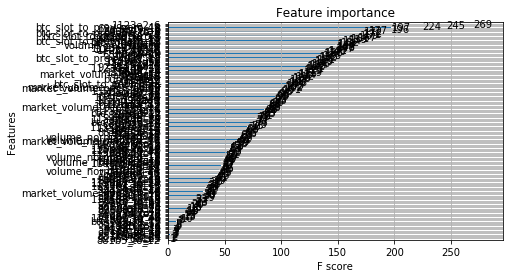

In [109]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()

In [110]:
#print(model.feature_importances_)

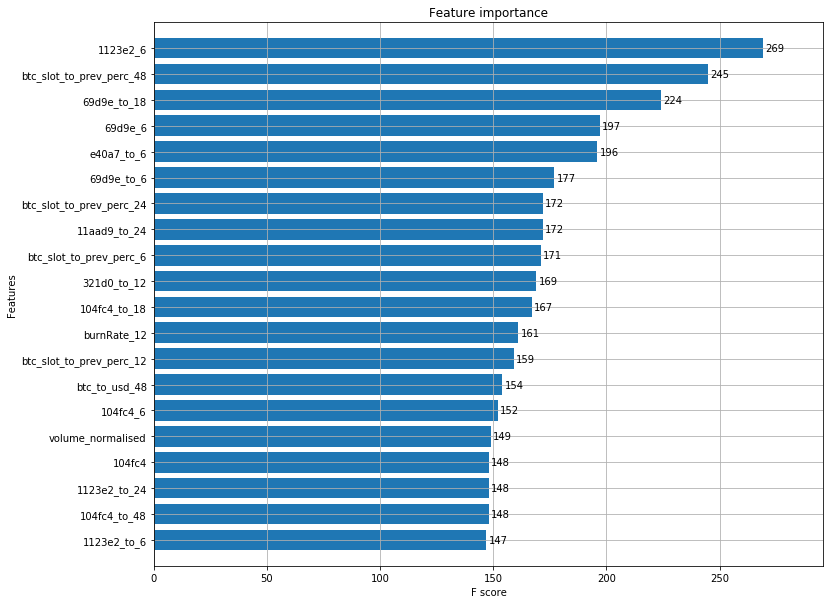

In [111]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score

In [113]:
x_train = features_onchain_merged.iloc[:658]
x_test = features_onchain_merged.iloc[659:]
y_train = Y[:658]
y_test = Y[659:]
print(len(x_train), len(x_test), len(y_train), len(y_test))
lr_char = LogisticRegression(solver='sag', verbose=2, multi_class='multinomial')
lr_char.fit(x_train, y_train)
y_pred_char = lr_char.predict(x_test)
print("test accuracy: {}".format(accuracy_score(y_test, y_pred_char)))
y_pred_train = lr_char.predict(x_train)
print("train accuracy {}" .format(accuracy_score(y_train, y_pred_train)))

(658, 73, 658, 73)
max_iter reached after 1 seconds
test accuracy: 0.301369863014
train accuracy 0.433130699088


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
